In [20]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from IPython.display import clear_output

In [21]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [22]:
plotly.offline.init_notebook_mode(connected=True)

In [23]:
import sys
sys.path.append("../pyfiles/")
from util import * 
from dataset import * 
from model import * 
from util_notebook import *

# Get celebA dataset

In [24]:
label_discription = [
    "male, smiling",
    "male, not smiling",
    "female, smiling",
    "female, not smiling"
]

In [25]:
root = "./../../dataset/celebA/img/"
label_root = "./../../dataset/celebA/label_folder/"

In [26]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
# 40 young
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32] 

In [27]:
classes = tuple(range(2**len(dataset_label["class"])))
cl = get_class_label(len(dataset_label["class"]))
classes

(0, 1, 2, 3)

In [28]:
transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    MinMax(True),
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    MinMax(True),
])

In [29]:
each_train_num = 10000000
each_val_num = 0
each_test_num = 100
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
len(dataset), len(testset)

(134530, 400)

0


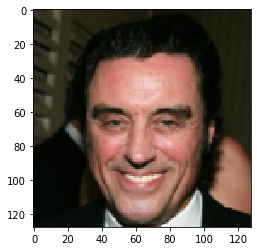

In [30]:
data = dataloader.dataset[24]
img = data[0]
image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
print(data[1])
plt.imshow(image)

## Algorithm

# conditional GAN

In [31]:
torch.cuda.set_device("cuda:1")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
# ---- adjustable parameters ---- #
ndim = 8 # the dimension of noise vector, indicating the style
nch_in = 3
nch = 64
reduce = 2
num_cls = 2
res_num = 6
dis_reduce = 2
dis_nch = 64
dis_num_cls = 4

ref_label = np.eye(len(classes))
criterion = nn.MSELoss()
criterion_class = nn.MSELoss()

In [33]:
import pandas as pd

models = [[10, 0],
          [10, 1],
          [5, 5]]

pd.DataFrame(np.array(models), columns=["cycle", "idt"])

,cycle,idt
0,10,0
1,10,1
2,5,5


In [34]:
###############################################
############ adjustable parameters ############

###############################################
###############################################

model_type = "nopretraining" # "nopretraining", "gradattention", "pretrained"
restriction_type = "proposedKL" # "conventionalKL", "proposedKL"
attention_mode = "" # this will be available when you set 'model_type' as "gradattention": "relu", "relumodified"
styleINdataset = False

if restriction_type == "conventionalKL":
    encoded_feature = "latent" # "latent" or "mu"
elif restriction_type == "proposedKL":
    encoded_feature = "mu" # "latent" or "mu"
if styleINdataset:
    styleINdataset_or_not = "styleINdataset_"
else:
    styleINdataset_or_not = ""

lbd = {}
lbd["cycle"] = 5
lbd["idt"] = 5
lbd["class"] = 1
lbd["reg"] = 0.5
lbd["idt_reg"] = 0.5
lbd["gp"] = 0
lbd["consis_reg"] = 0

if restriction_type == "conventionalKL":
    lbd["KL"] = 0.1
    lbd["batch_KL"] = 0
    lbd["corr_enc"] = 0
    lbd["hist"] = 0
elif restriction_type == "proposedKL":
    lbd["KL"] = 0
    lbd["batch_KL"] = 10
    lbd["corr_enc"] = 100
    lbd["hist"] = 100

unrolled_k = 5

In [35]:
netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, "instance", num_con=ref_label.shape[1]+ndim).to(device)
netD = SingleDiscriminator_solo_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, "instance", ref_label.shape[1]).to(device)
netE = Encoder_original(nch_in, ndim, nch, 4, "instance", ref_label.shape[1]).to(device)
sg = SingleGAN_training_singleD([netG, netD, netE], [None, None, None], [criterion, criterion_class], 
                       lbd, unrolled_k, device, ref_label, ndim, None, encoded_feature)
sg.opt_sche_initialization()

In [36]:
load_epoch = 30
dir = "./../data/parameters/02/"
# dir = "instant_model_parameter/"
gen_path = dir + f"gen_singleD_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"
enc_path = dir + f"enc_singleD_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"

gen_model = torch.load(gen_path)
enc_model = torch.load(enc_path)

netG.load_state_dict(gen_model)
netE.load_state_dict(enc_model)
gen_path

'./../data/parameters/02/gen_singleD_SingleGAN_idt5_cycle5_KL0_reg0.5_idtreg0.5_bKL10_correnc100_hist100_unrolledk5_epoch30'

In [37]:
num = 100
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=num)

In [38]:
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=1000, shuffle=False)
for itr, data in enumerate(dataloader):
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    if itr==0:
        labels = cuda2cpu(data_label)
        samples = cuda2cpu(data_image)
    else:
        labels = np.concatenate([labels, cuda2cpu(data_label)], axis=0)
        samples = torch.cat([samples, cuda2cpu(data_image)], axis=0)

In [39]:
latent = np.random.randn(num, ndim)

In [40]:
index = len(testset) - 11
target_label = 2
data, label = get_samples(netG, netE, testset, index, latent, classes, ref_label, ndim, image_type="pil", batch=32, device=device, conventional_E=True)

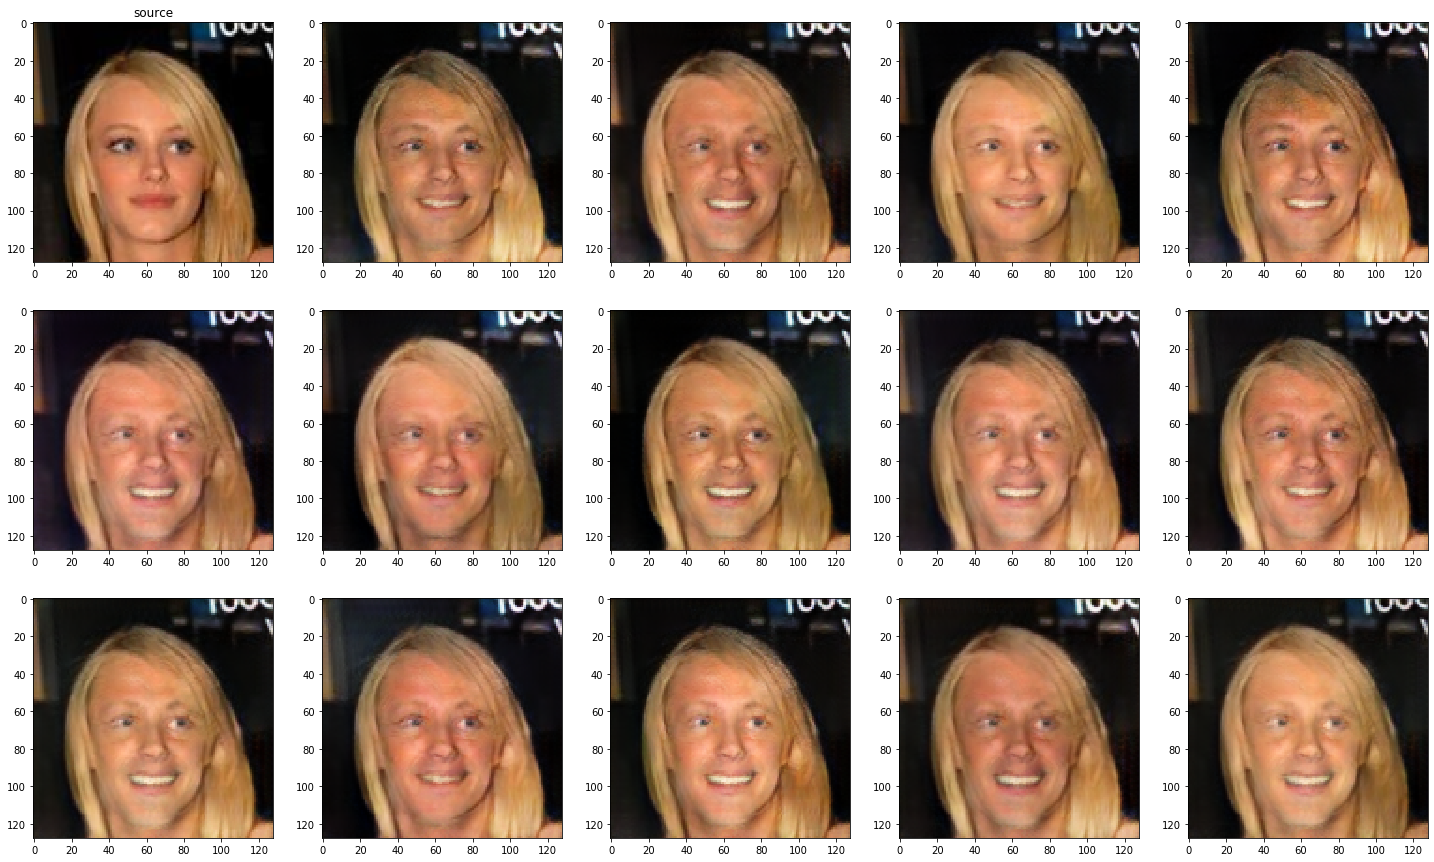

In [41]:
length = 3
width = 5
images = data["target"][0]

np.random.seed(0)
a = np.random.choice(np.arange(num), length*width-1, False)
fig = plt.figure(figsize=(5*width, 5*length))
index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(data["source"])
ax.set_title("source")

for i in range(length*width-1):
    index = i+2
    ax = fig.add_subplot(length, width, index)
    ax.imshow(images[a[i]])

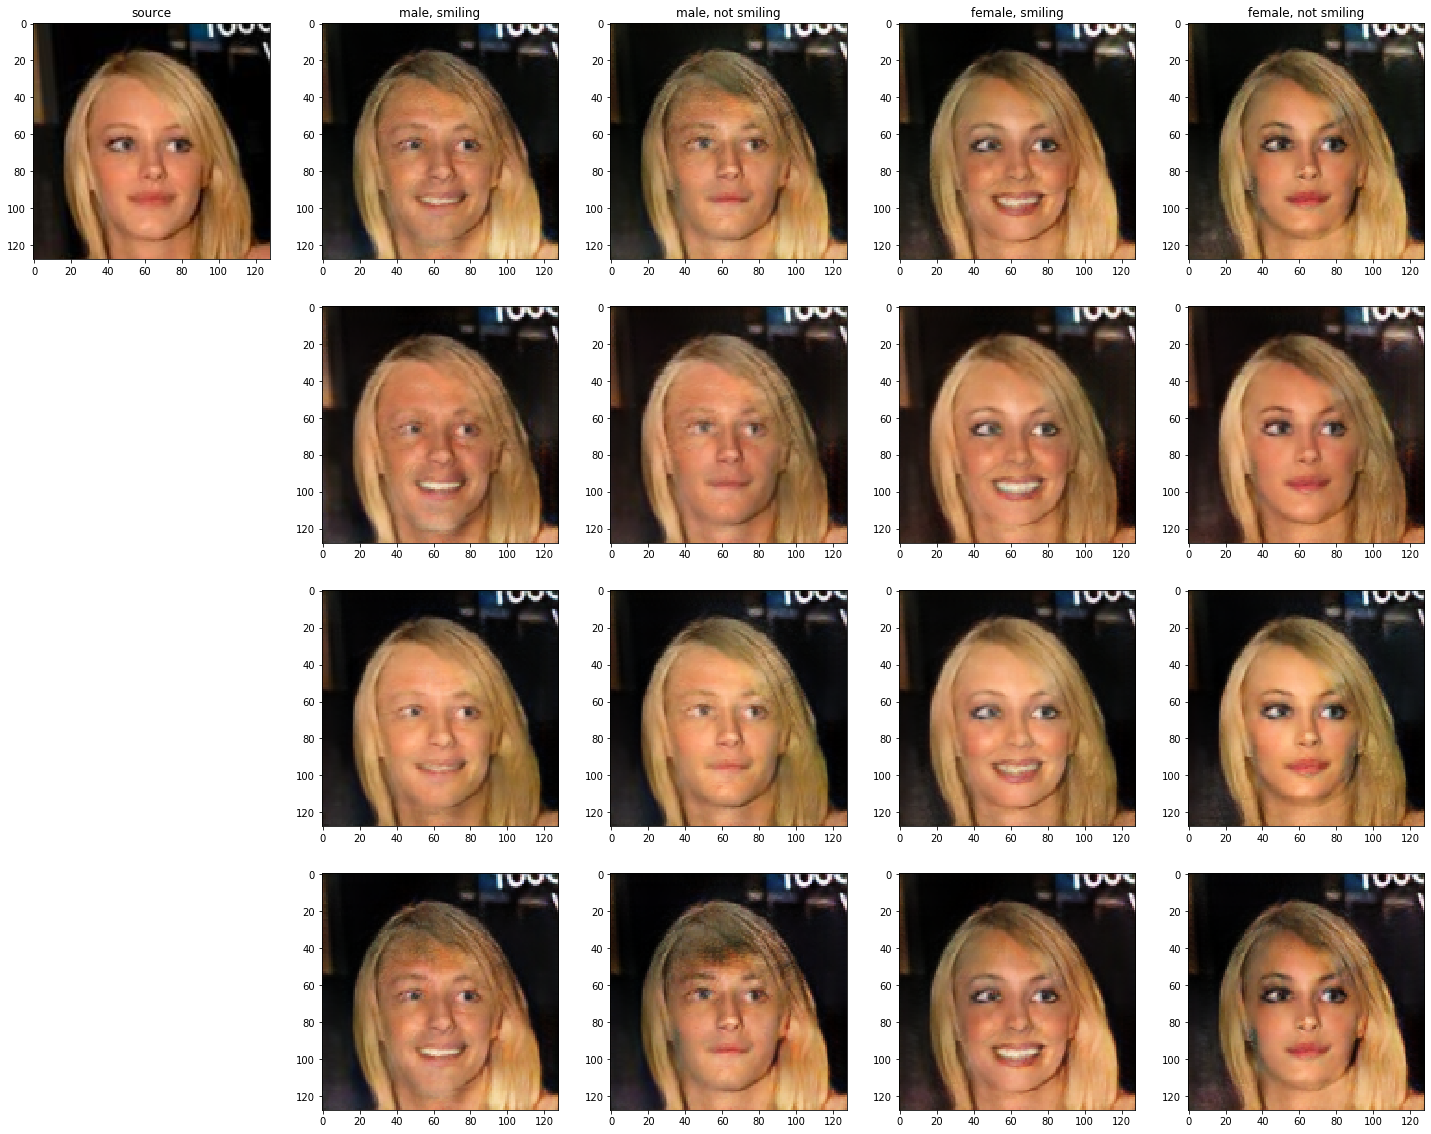

In [42]:
length = 4
images = data["target"]

width = len(classes)+1
fig = plt.figure(figsize=(5*width, 5*length))
np.random.seed(0)
a = np.random.choice(np.arange(num), length, False)
index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(data["source"])
ax.set_title("source")

for i in range(length):
    for j in classes:
        index = i*(len(classes)+1)+j+2
        ax = fig.add_subplot(length, width, index)
        ax.imshow(images[j][a[i]])
        if i == 0:
            ax.set_title(label_discription[j])

## PRDC

### data

In [43]:
num = 1000
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=num)

In [44]:
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=128, shuffle=False)
for itr, data in enumerate(dataloader):
    netE.eval()
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    if styleINdataset:
        _, mu, _, _, _ = netE(data_image)
    if itr==0:
        if styleINdataset:
            mu_list = cuda2cpu(mu)
        labels = cuda2cpu(data_label)
        samples = cuda2cpu(data_image)
    else:
        if styleINdataset:
            mu_list = np.concatenate([mu_list, cuda2cpu(mu)], axis=0)
        labels = np.concatenate([labels, cuda2cpu(data_label)], axis=0)
        samples = torch.cat([samples, cuda2cpu(data_image)], axis=0)
if styleINdataset:
    latent = mu_list
else:
    latent = np.random.randn(num, ndim)

In [46]:
index = len(testset) - 11
# index = len(testset)//len(classes) - 16
if styleINdataset:
    latent_list = [latent[labels==0],
                   latent[labels==1],
                   latent[labels==2],
                   latent[labels==3]]
else:
    latent_list = latent
data, label = get_samples(netG, netE, testset, index, latent_list, classes, ref_label, ndim, image_type="tensor", batch=32, device=device, conventional_E=True)

### evaluation

In [47]:
fe_list = ["vgg-initialization", 
           "vgg-ImageNet", 
           "vgg-CelebA"]

In [49]:
from evaluation import *

In [50]:
ge = GAN_evaluation(fe_list[0], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 0.804, 'recall': 0.0, 'density': 0.3376, 'coverage': 0.035}

In [51]:
ge = GAN_evaluation(fe_list[1], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 0.949,
 'recall': 0.0,
 'density': 0.8230000000000001,
 'coverage': 0.048}

In [52]:
ge = GAN_evaluation(fe_list[2], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 0.996, 'recall': 0.262, 'density': 1.1206, 'coverage': 0.242}

In [54]:
def evaluation_init(fe_list, classes, metrics):
    GAN_eval = {}
    for fe in fe_list:
        GAN_eval[fe] = {}
        for source_label in classes:
            GAN_eval[fe][source_label] = {}
            for target_label in classes:
                GAN_eval[fe][source_label][target_label] = {}
                GAN_eval[fe][source_label][target_label] = {}
                for metric in metrics.keys():
                    GAN_eval[fe][source_label][target_label][metric] = []
    return GAN_eval

In [ ]:
sample_num = 100
init = True

if init:
    GAN_eval = evaluation_init(fe_list, classes, metrics)
    start = 0
else:
    start = len(GAN_eval[fe_list[0]][0][0]["coverage"])
    
for i in range(sample_num):
    clear_output(wait=True)
    print(i)
    for source_label in classes:
        index = source_label*num + (start+i)
        data, label = get_samples(netG, netE, testset, index, latent_list, classes, ref_label, ndim, image_type="tensor", batch=32, device=device, conventional_E=True)
        for target_label in classes:
            for fe in fe_list:
                ge = GAN_evaluation(fe, device, classes, [target_label])
                metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
                for metric in metrics.keys():
                    GAN_eval[fe][source_label][target_label][metric].append(metrics[metric])

1
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000


In [ ]:
save = True
path = f"../data/results/02/02_GAN_evaluation_singleD.pkl"

if save:
    pickle_save(GAN_eval, path)